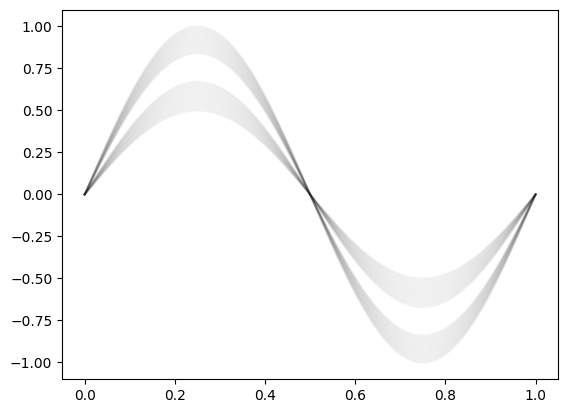

training X  (32, 200, 1)
training Y  (32, 200, 1)
loss  0.5090752728873916
Saving model
loss  1.5742264916181687
loss  0.38236381726989477
Saving model
loss  0.35893607542625183
Saving model
loss  0.7687387207909987
loss  0.8667953710930462
loss  0.24509498463736168
Saving model
loss  0.3271460778700115
loss  0.2886309448949832
loss  0.6138712108445534
loss  0.3694115501360895
loss  0.23694504109959702
Saving model
loss  0.6372555625672542
loss  0.9569120665161053
loss  0.1687053683264842
Saving model
loss  0.38395755676151433
loss  0.1466425672417324
Saving model
loss  1.495774935821269
loss  0.015617818503197878
Saving model
loss  -0.17737195793768534
Saving model
loss  0.31545334720302654
loss  0.6290122829251922
loss  0.9339428024101322
loss  0.2125063605741433
loss  -0.20046999246549801
Saving model
loss  -0.1437064327360631
loss  0.014199982436110314
loss  1.490367539129504
loss  -0.2402996458835267
Saving model
loss  0.4573148955788193
loss  0.8611584987404757
loss  1.0354817277

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

time_len = 200

def generate_demonstrations(time_len = 200, params = None, title = None):
    def dist_generator(d, x, param, noise = 0):
        f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+param[1]
        return f+(noise*(np.random.rand()-0.5)/100.)
    def sinx(x, frequency, amplitude, phase):
        return amplitude * math.sin(2 * math.pi * frequency * x + phase)
    
    num_demo = 32
    frequencies = [1]
    amplitudes_0 = np.linspace(0.5,0.67,num_demo//2)
    amplitudes_1 = np.linspace(0.84,1.0,num_demo//2)
    amplitudes = np.concatenate((amplitudes_0, amplitudes_1))
    phases = [0] 

    #fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((num_demo,time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((num_demo,time_len,1))
    for d in range(num_demo):
        for i in range(time_len):
            values[d,i] = sinx(times[0][i][0], frequencies[d % len(frequencies)], amplitudes[d % len(amplitudes)], phases[d % len(phases)])
        plt.plot(times[d], values[d], color="black", alpha=0.05)
    #plt.title(title+' Demonstrations')
    #plt.ylabel('Y')
    #plt.xlabel('time (t)')
    plt.show()
    return times, values

# gets random number of random obs. points from a random trajectory. Also gets a 
# random target (x,y) from the same trajectory
def get_training_sample():
    
    n = np.random.randint(0,OBS_MAX)+1
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    observations[:,:d_x] = X[d,perm[:n]]
    observations[:,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(observations), torch.from_numpy(target_X), torch.from_numpy(target_Y)

def log_prob_loss(output, y_target): 
    mean, std = output.chunk(2, dim=-1)
    std = F.softplus(std)
    dist = D.Independent(D.Normal(loc=mean, scale=std), 1)  # (d_y distributions)
    return -torch.mean(dist.log_prob(y_target)) 

class CNMP(nn.Module):
    def __init__(self, d_x, d_y):
        super(CNMP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(d_x + d_y, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d_x + 128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 2*d_y)
        )
    def forward(self, obs, x_tar): # obs is (n, d_x + d_y)

        r = self.encoder(obs) # (n,128)
        r_avg = torch.mean(r, 0) # (1,128)
        r_avg = r_avg.repeat(x_tar.shape[0],1) # Duplicating general representation for every target_t

        concat = torch.cat((r_avg, x_tar), dim=-1)
        output = self.decoder(concat) # (2*d_y,)
        return output

############################################################################################################

X, Y = generate_demonstrations(time_len=200, params=np.array([[0.6,-0.1],[0.5,-0.23],[0.4,-0.43],[-0.6,0.1],[-0.5,0.23],[-0.4,0.43]]), title='Training')


print('training X ', X.shape)
print('training Y ',Y.shape)

OBS_MAX = 5
d_x = X.shape[-1]
d_y = Y.shape[-1]
d_N = X.shape[0]

model = CNMP(d_x, d_y).double()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#print(model.eval())

losses = []

for i in range(300000):

    obs, x_tar, y_tar = get_training_sample()

    optimizer.zero_grad()

    output = model(obs, x_tar)
    loss = log_prob_loss(output, y_tar)
    
    loss.backward()
    optimizer.step()
    #print('loss ', loss.item())

    if i % 100 == 0:
        #print('iteration ', i)
        print('loss ', loss.item())
        losses.append(loss.item())
        if loss.item() == min(losses):
            print("Saving model")
            torch.save(model.state_dict(), 'best_model.pth')

In [14]:
from cProfile import label


def predict_model(observations, target_X, plot = True):
    d_N = X.shape[0]
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    with torch.no_grad():
        prediction = model(torch.from_numpy(observations),torch.from_numpy(target_X)).numpy()
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(10,10))
            for j in range(d_N):
                if j == 0:
                    plt.plot(X[j,:,0],Y[j,:,i], color="black", alpha=0.05, label="Demonstrations") # assuming X[j,:,0] is time
                else:
                    plt.plot(X[j,:,0],Y[j,:,i], color="black", alpha=0.05)
            plt.title("CNMP Prediction")
            plt.plot(X[j,:,0],predicted_Y[:,i],color='red', label='Predicted')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.1)
            plt.scatter(observations[:,0],observations[:,d_x+i],marker="X",color='black', label='Observations')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()  
    return predicted_Y, predicted_std

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_77076/387755709.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_mo

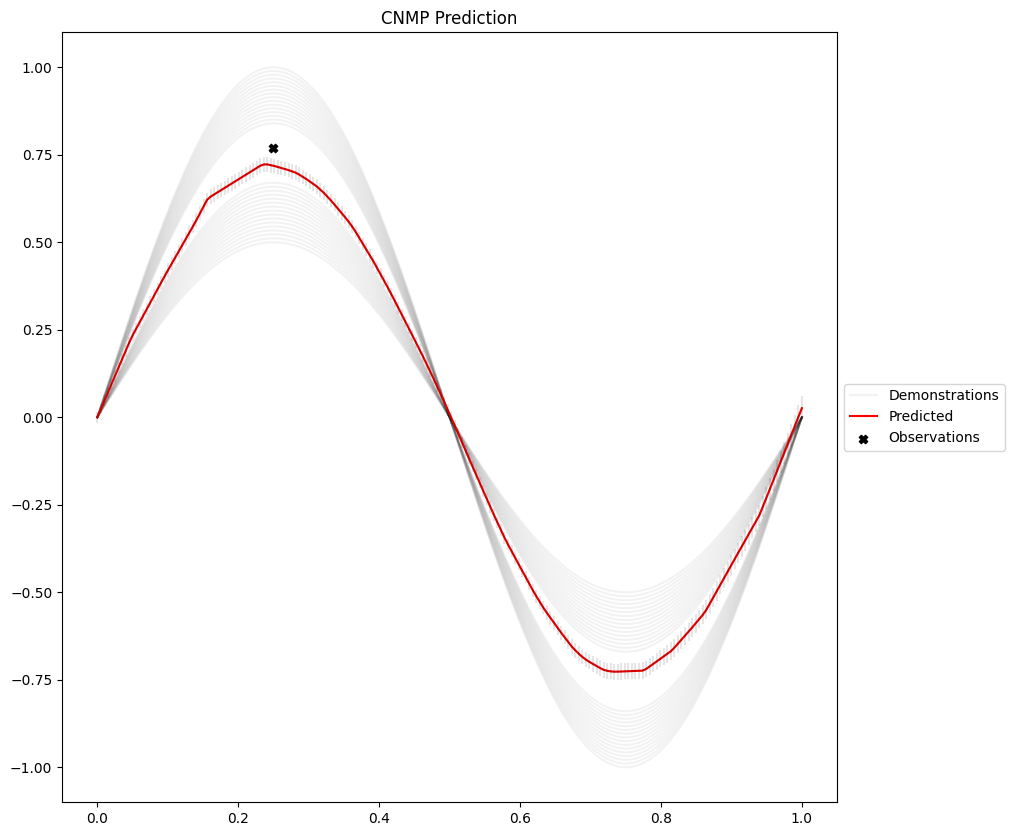

In [15]:
best_model = CNMP(d_x, d_y).double()
best_model.load_state_dict(torch.load('best_model.pth'))

t = 0.25
min_y = np.min(Y[:, int(t * time_len)])
max_y = np.max(Y[:, int(t * time_len)])
interval_y = np.linspace(min_y-0.1, max_y+0.1, 20)
predicted_Y, predicted_std = predict_model(np.array([[0.25, interval_y[10]]]),X[0])